# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Update note
November 2018 - Modified by Gaston Snaider under the course "Taller de Programacion III" of the University of Buenos Aires.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.
The network also ```requires a network_usage.log```, where the network usage speed per time is saved during the test.

In [20]:
BATCHES_DIR = '/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/09-logs-rasp3-1dic2018/batch-test-report'
TEST_CONFIG_FILE = '/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/09-logs-rasp3-1dic2018/description.yml'
NET_USAGE_FILE='/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/09-logs-rasp3-1dic2018/network_usage.log'

In [21]:
NET_USAGE_SEPARATOR='|'

# Setup and import everything
%matplotlib notebook

import datetime
import math
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt

from processor import analysis, reports

from IPython.display import display

base_directory = BATCHES_DIR
with open(TEST_CONFIG_FILE) as fp:
    batch_description = yaml.load(fp)
batch_description

{'intervals': [{'duration_minutes': 60, 'speed_percentage': 0},
  {'duration_minutes': 60, 'speed_percentage': 25},
  {'duration_minutes': 60, 'speed_percentage': 50},
  {'duration_minutes': 60, 'speed_percentage': 75},
  {'duration_minutes': 60, 'speed_percentage': 100},
  {'duration_minutes': 60, 'speed_percentage': 0}],
 'max_speed_kbps': 24000,
 'network_interface': 'wlan0',
 'start_time': 1543644000.07122}

In [22]:
def get_analyzer_results(reports_batch_dir):
    rh = reports.ReportHandler(os.path.join(base_directory, reports_batch_dir))
    ip, obs_set = rh.get_ip_and_processable_observations()
    if ip is None and obs_set is None:
        raise ValueError('Reports batch directory {} has no reports to use!'.format(reports_batch_dir))
    analyzer = analysis.Analyzer(obs_set)
    results = analyzer.get_results()
    return results

def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    
    test_start_epoch = batch_description['start_time']
    experiment_start_epoch = test_start_epoch
    for experiment_configuration in batch_description['intervals']:
        lapse = experiment_configuration['duration_minutes'] * 60
        start = experiment_start_epoch
        end = experiment_start_epoch + lapse
        
        if start <= batch_start_time < end:
            batch_starting_conf = experiment_configuration
            batch_starting_conf_start_epoch = start
        if start <= batch_end_time < end:
            batch_ending_conf = experiment_configuration
            batch_ending_conf_start_epoch = start
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
        
        # Increment the start epoch for the next experiment.
        experiment_start_epoch = end
        
    if batch_starting_conf is None and batch_ending_conf is None:
        return None
#         raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
#                                                                                           batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed_percentage'] / 100
    elif batch_starting_conf['speed_percentage'] / 100 == batch_ending_conf['speed_percentage'] / 100:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    else:
        # TODO actualizar esta parte con el nuevo yml
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf_start_epoch + batch_starting_conf['duration_minutes']*60 - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf_start_epoch
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed_percentage'] / 100 +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed_percentage'] / 100)
    return expected_usage
    

In [23]:
net_usage_time = []
net_usage_speed = []
with open(NET_USAGE_FILE) as net_usage_file:
  # Skip header
  next(net_usage_file)
  for line in net_usage_file:
    (epoch, speed) = line.split(NET_USAGE_SEPARATOR)
    usage_time =  datetime.datetime.fromtimestamp(float(epoch))
    # TODO verify the units in which the speed comes. 
    # By dividing over 1024*64, we get it to match the other plots in kbps.
    speed_kbps = int(speed) / (1024.0 * 64.0)
    # Skip odd negative values which break the plot.
    if speed_kbps >= 0:
      net_usage_time.append(usage_time)
      net_usage_speed.append(speed_kbps)

In [24]:
columns = ['batch_start_timestamp', 'batch_end_timestamp',
           'batch_start_time', 'batch_end_time',
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage', 'error', 'relative_error']
data = pd.DataFrame(columns=columns)

for reports_batch_dir in sorted(os.listdir(base_directory)):
    reports_batch_dir_path = os.path.join(base_directory, reports_batch_dir)
    if not os.path.isdir(reports_batch_dir_path): continue
    results = get_analyzer_results(reports_batch_dir_path)
    batch_start_time = int(reports_batch_dir)
    batch_end_time = results['timestamp']
    expected_usage = get_expected_usage(batch_start_time, batch_end_time)
    if expected_usage is None: continue
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         datetime.datetime.fromtimestamp(batch_start_time),
                         datetime.datetime.fromtimestamp(batch_end_time),
                         results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                         results['downstream']['quality'], results['downstream']['usage'], 
                         results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                         results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage, 
                         math.fabs(expected_usage - results['downstream']['usage']), 
                         (math.fabs(expected_usage - results['downstream']['usage']) / expected_usage) 
                         if expected_usage != 0 else math.fabs(expected_usage - results['downstream']['usage']))
                       ], 
                       columns=columns)
    data = data.append(df_)
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)

,batch_start_timestamp,batch_end_timestamp,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,upstream_quality,upstream_usage,expected_downstream_usage,error,relative_error
0,1543644072,1543644892,2018-12-01 03:01:12,2018-12-01 03:14:52,0.547967,0.718500,1.0,0.057604,0.571026,0.593097,1.0,0.073350,0.000000,0.057604,0.057604
1,1543644620,1543645225,2018-12-01 03:10:20,2018-12-01 03:20:25,0.536222,0.239561,1.0,0.053269,0.525595,0.329318,1.0,0.116505,0.000000,0.053269,0.053269
2,1543645169,1543646271,2018-12-01 03:19:29,2018-12-01 03:37:51,0.523764,0.300924,1.0,0.097826,0.454151,0.393802,1.0,0.208738,0.000000,0.097826,0.097826
3,1543645718,1543646847,2018-12-01 03:28:38,2018-12-01 03:47:27,0.517434,0.603987,1.0,0.071078,0.493692,0.218691,1.0,0.119540,0.000000,0.071078,0.071078
4,1543646267,1543647083,2018-12-01 03:37:47,2018-12-01 03:51:23,0.506243,1.017110,0.0,0.049383,0.574555,0.625145,1.0,0.082725,0.000000,0.049383,0.049383
5,1543646816,1543648024,2018-12-01 03:46:56,2018-12-01 04:07:04,0.592071,0.513795,1.0,0.197101,0.556858,0.706131,1.0,0.687651,0.087734,0.109368,1.246590
6,1543647365,1543648406,2018-12-01 03:56:05,2018-12-01 04:13:26,0.527943,0.497528,1.0,0.307359,0.544763,0.420572,1.0,0.544662,0.193547,0.113813,0.588036
7,1543647975,1543648621,2018-12-01 04:06:15,2018-12-01 04:17:01,0.572749,0.452924,1.0,0.326829,0.526274,0.490772,1.0,0.553922,0.250000,0.076829,0.307317
8,1543648524,1543649552,2018-12-01 04:15:24,2018-12-01 04:32:32,0.522360,0.418567,1.0,0.298611,0.548275,0.563156,1.0,0.543578,0.250000,0.048611,0.194444
9,1543649075,1543650018,2018-12-01 04:24:35,2018-12-01 04:40:18,0.534135,0.482295,1.0,0.268765,0.522913,0.124209,1.0,0.539130,0.250000,0.018765,0.075061


<IPython.core.display.Javascript object>


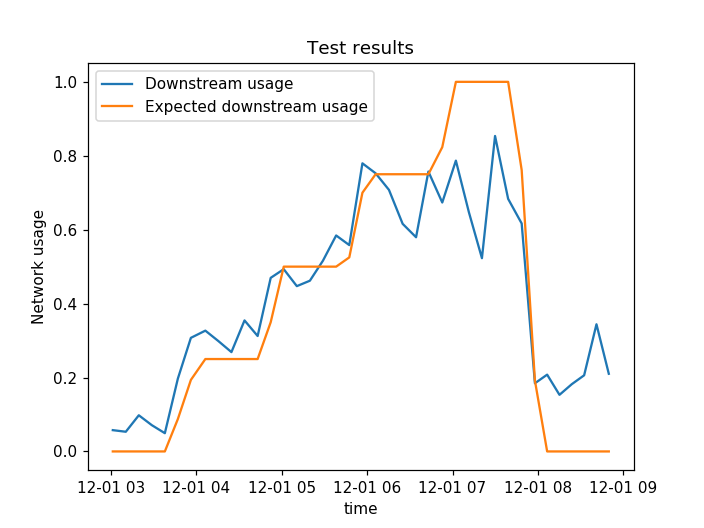

In [27]:
plt.figure()
plt.plot(data['batch_start_time'], data['downstream_usage'])
plt.plot(data['batch_start_time'], data['expected_downstream_usage'])
plt.xlabel('time')
plt.ylabel('Network usage')
plt.title('Test results')
plt.legend(['Downstream usage', 'Expected downstream usage'])
plt.show()

<IPython.core.display.Javascript object>


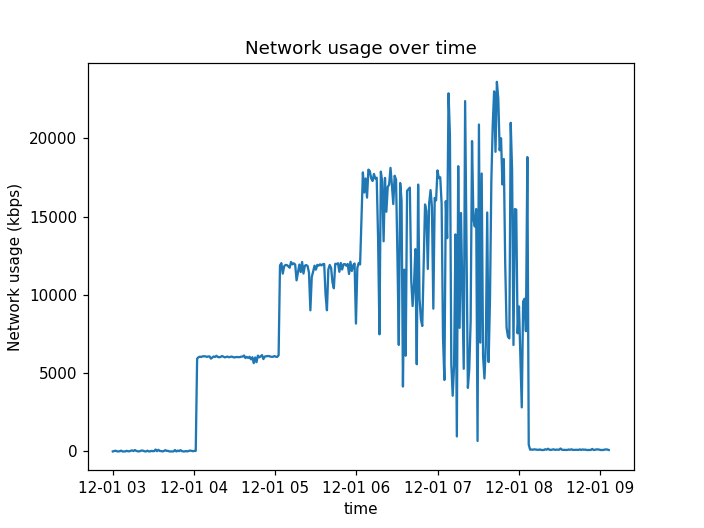

In [25]:
plt.figure()
plt.plot(net_usage_time, net_usage_speed)
plt.xlabel('time')
plt.ylabel('Network usage (kbps)')
plt.title('Network usage over time')
plt.show()

<IPython.core.display.Javascript object>


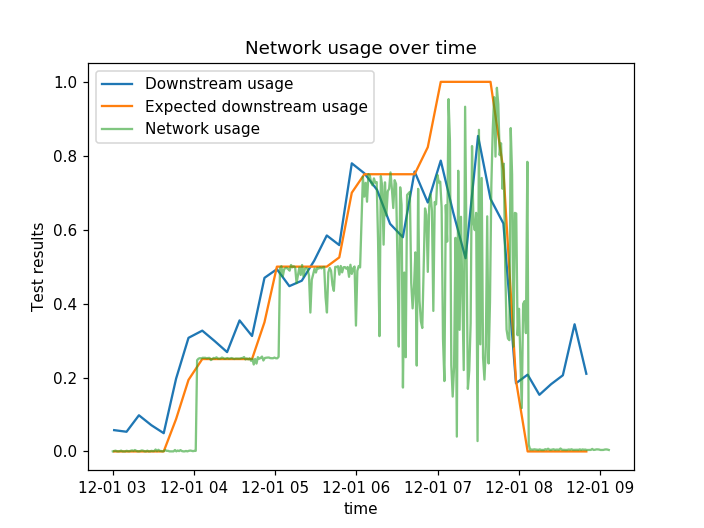

In [28]:
normalized_net_usage = [speed_kbps / batch_description['max_speed_kbps'] for speed_kbps in net_usage_speed]
plt.figure()
plt.plot(data['batch_start_time'], data['downstream_usage'])
plt.plot(data['batch_start_time'], data['expected_downstream_usage'])
plt.plot(net_usage_time, normalized_net_usage, alpha=0.6)
plt.xlabel('time')
plt.ylabel('Test results')
plt.title('Network usage over time')
plt.legend(['Downstream usage', 'Expected downstream usage', 'Network usage'])
plt.show()

In [8]:
display(data[['error', 'relative_error']].describe(include='all'))

,error,relative_error
count,39.000000,39.000000
mean,0.154212,0.309417
std,0.166222,0.401568
min,0.002174,0.002174
25%,0.022031,0.039027
50%,0.144981,0.232048
75%,0.202871,0.417277
max,0.939467,2.385244


<IPython.core.display.Javascript object>


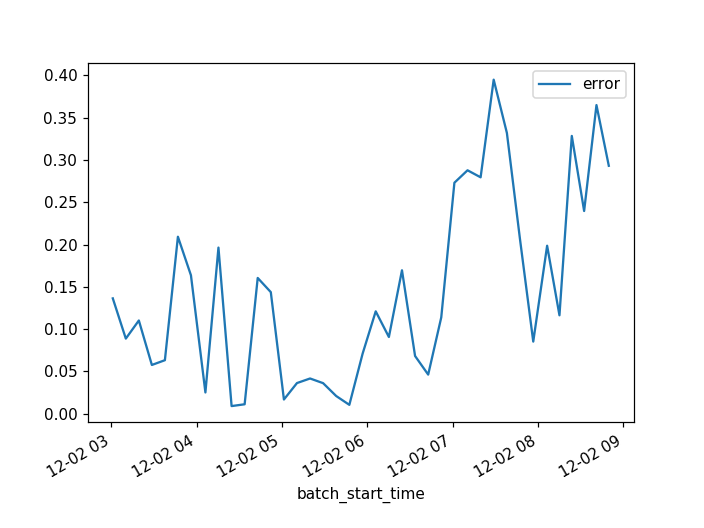

In [18]:
data.plot(x='batch_start_time', y='error', kind='line')

<IPython.core.display.Javascript object>


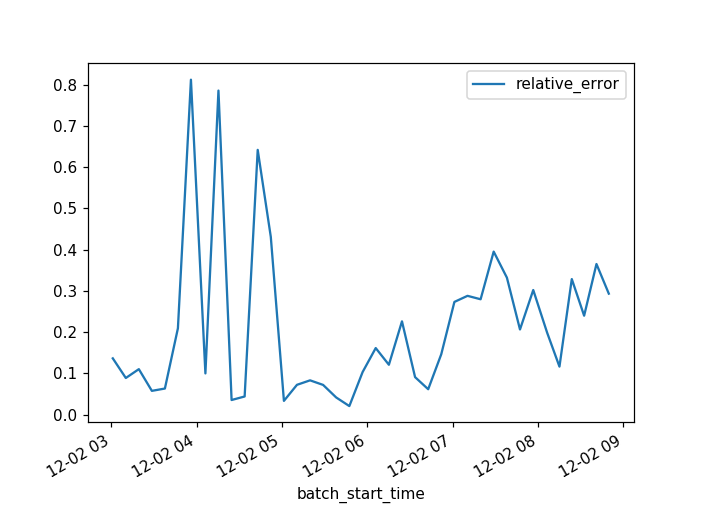

In [19]:
data.plot(x='batch_start_time', y='relative_error', kind='line')